## Notebook to generate collision rate violators for any RMG job while running

In [1]:
import logging
import numpy as np
import os
import sys

In [2]:
import os, sys
rmg_path = '/home/blais.ch/RMG_Base_env/RMG-Py'
if rmg_path not in sys.path:
    sys.path.append(rmg_path)
sys.path

import rmgpy
from rmgpy.chemkin import load_chemkin_file
from rmgpy.rmgobject import RMGObject, expand_to_dict, recursive_make_object

print(f"RMG-Py Version {rmgpy.__version__}")
print(rmgpy.__file__)

RMG-Py Version 3.0.0
/home/blais.ch/RMG_Base_env/RMG-Py/rmgpy/__init__.py


In [3]:
chemkin_file = '/scratch/blais.ch/HAN/_10_HAN_RUN_20Apr2020/HAN/HAN_Runs/CatArea2Vol_1e3/chemkin/chem_annotated-gas.inp'
chemkin_folder = os.path.split(chemkin_file)[0]
species_dictionary_file = os.path.join(chemkin_folder, 'species_dictionary.txt')
transport_file = os.path.join(chemkin_folder, 'tran.dat')

In [4]:
species, reactions = rmgpy.chemkin.load_chemkin_file(
                    chemkin_file, species_dictionary_file,transport_path=transport_file,
                    check_duplicates=False, use_chemkin_names=True,read_comments=True)



In [5]:
species_dict = {rmgpy.chemkin.get_species_identifier(s): s for s in species}
species_dict.keys()

dict_keys(['Ne', 'NH3(2)', 'NH2OH(3)', 'HNO3(4)', 'CH3OH(5)', 'H2O(6)', 'N2(7)', 'O2(8)', 'NO2(9)', 'NO(10)', 'N2O(11)', 'CO2(12)', 'H2(13)', 'CO(14)', 'CH4(15)', 'C2H6(16)', 'CH2O(17)', 'CH3(18)', 'C3H8(19)', 'H(20)', 'C2H5(21)', 'HCO(22)', 'CH3CHO(23)', 'OH(24)', 'C2H4(25)', 'O(36)', 'Ar(37)', 'HO2(39)', 'H2O2(40)', 'HOCO(41)', 'CH2(42)', 'CH2(S)(43)', 'CH(44)', 'CH2OH(45)', 'CH3O(46)', 'HCOH(47)', 'CH3OO(48)', 'CH2CO(49)', 'C2H3(50)', 'C(51)', 'C2H2(52)', 'C2H(53)', 'CH3OOH(54)', 'CH2OOH(55)', 'HOCH2O(56)', 'HOCHO(57)', 'C2H5O(58)', 'C2H5O2(59)', 'C2H5O2(60)', 'cC2H4O(61)', 'CH2CHO(62)', 'H2CC(63)', 'CH3CO(64)', 'C2H4O(65)', 'C2H5O(66)', 'C2H3O2(67)', 'CHCHO(68)', 'OCHCHO(69)', 'HCCO(70)', 'HCCOH(71)', 'CHCHOH(72)', 'C2(73)', 'C2O(74)', 'C2H6O(75)', 'C2H5O(76)', 'C2H5O3(77)', 'cC2H3O(78)', 'C2H3O3(79)', 'OCHCO(80)', 'C2H6O2(81)', 'C2H5O2(82)', 'C2H4O2(83)', 'OCHO(84)', 'NH2(85)', 'NH(86)', 'HNO(87)', 'H2NO(88)', 'HON(89)', 'N(90)', 'NNH(91)', 'HONO(92)', 'HNOH(93)', 'HNO2(94)', 'NO3

In [6]:
def check_collision_limit_violation(self, t_min, t_max, p_min, p_max):
        """
        Warn if a core reaction violates the collision limit rate in either the forward or reverse direction
        at the relevant extreme T/P conditions. Assuming a monotonic behaviour of the kinetics.
        Returns a list with the reaction object and the direction in which the violation was detected.
        """
        conditions = [[t_min, p_min]]
        if t_min != t_max:
            conditions.append([t_max, p_min])
        if self.kinetics.is_pressure_dependent() and p_max != p_min:
            conditions.append([t_min, p_max])
            if t_min != t_max:
                conditions.append([t_max, p_max])
        logging.debug("Checking whether reaction {0} violates the collision rate limit...".format(self))
        violator_list = []
        kf_list = []
        kr_list = []
        collision_limit_f = []
        collision_limit_r = []
        for condition in conditions:
            if len(self.reactants) >= 2:
                try:
                    collision_limit_f.append(self.calculate_coll_limit(temp=condition[0], reverse=False))
                except ValueError:
                    continue
                else:
                    kf_list.append(self.get_rate_coefficient(condition[0], condition[1]))
            if len(self.products) >= 2:
                try:
                    collision_limit_r.append(self.calculate_coll_limit(temp=condition[0], reverse=True))
                except ValueError:
                    continue
                else:
                    kr_list.append(self.generate_reverse_rate_coefficient().get_rate_coefficient(condition[0], condition[1]))
        if len(self.reactants) >= 2:
            for i, k in enumerate(kf_list):
                if k > collision_limit_f[i]:
                    ratio = k / collision_limit_f[i]
                    condition = '{0} K, {1:.1f} bar'.format(conditions[i][0], conditions[i][1] / 1e5)
                    violator_list.append([self, 'forward', ratio, condition])
        if len(self.products) >= 2:
            for i, k in enumerate(kr_list):
                if k > collision_limit_r[i]:
                    ratio = k / collision_limit_r[i]
                    condition = '{0} K, {1:.1f} bar'.format(conditions[i][0], conditions[i][1] / 1e5)
                    violator_list.append([self, 'reverse', ratio, condition])
        return violator_list

In [7]:
import numpy as np
np.linalg.LinAlgError

numpy.linalg.linalg.LinAlgError

In [8]:
violators = []
for r in reactions:
    try:
        v = check_collision_limit_violation(r, 150+273,1000, 1e5, 30e5)
    except np.linalg.LinAlgError:
        print(f"LinAlgError checking {r}")
    if v:
        print(r)
        violators.extend(v)

NO(10) + NO(10) <=> N2O2(378)
NO2(9) + NO2(9) <=> NO(10) + NO3(95)
S(1436) <=> NO2NO(328) + HNO(87)
NO2(9) + CH2OH(45) <=> S(1677)
H2NO(88) + CH2OH(45) <=> S(1693)
CH3(18) <=> H2(13) + CH(44)
CH3(18) <=> H(20) + CH2(42)
CH2(42) <=> H(20) + CH(44)
CH2(42) <=> H2(13) + C(51)
C2H2(52) <=> H(20) + C2H(53)
C2O(74) <=> C(51) + CO(14)
HO2(39) + C2H5O3(77) => O2(8) + CH2OH(45) + CH2OOH(55)
CH2O(17) + C2H5O3(77) => HCO(22) + CH2OH(45) + CH2OOH(55)
OH(24) + H2N2(97) => NO(10) + H(20) + NH2(85)
HCN(100) <=> H(20) + CN(101)
H2NO(88) + CH3(18) <=> NH2(85) + CH3O(46)
NH3(2) + CH(44) <=> H(20) + H(20) + H2CN(114)
H2(13) + NCN(108) <=> H(20) + HNCN(107)
H(20) + HNCNH(109) <=> H2(13) + HNCN(107)
O(36) + HNCNH(109) <=> OH(24) + HNCN(107)
H(20) + S(122) <=> H2(13) + S(123)
H(20) + C2H4N(145) <=> H(20) + C2H4N(147)
OH(24) + C2H4N(145) <=> HCNH(135) + CH2OH(45)
CH3NO(142) <=> NH2(85) + HCO(22)
CH3NO(142) <=> H(20) + H2NCO(146)
O(36) + C2H7N(157) <=> OH(24) + C2H6N(158)


In [9]:
from rmgpy.data.kinetics import TemplateReaction, LibraryReaction
from rmgpy.rmg.pdep import PDepReaction

In [10]:
violators.sort(key = lambda violator: -violator[2])

Text(0.5, 0, 'reaction index (of 1563 total)')

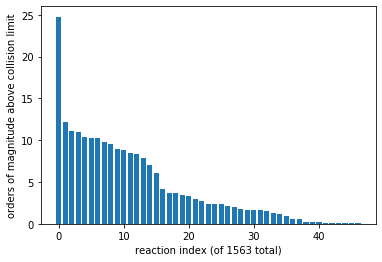

In [11]:
ratios = [np.log10(violator[2]) for violator in violators]
from matplotlib import pyplot as plt
plt.bar(np.arange(len(ratios)), ratios)
plt.ylabel("orders of magnitude above collision limit")
plt.xlabel(f"reaction index (of {len(reactions)} total)")

In [12]:
len(ratios), len(reactions)

(47, 1563)

In [13]:
for violator in violators[:100]:
    rxn_string = str(violator[0])
    direction = {'forward':'=>','reverse':'<='}[violator[1]]
    ratio = violator[2]
    print(f"{rxn_string.replace('<=>',direction) :48s}  {ratio :.1g}")

CH2O(17) + C2H5O3(77) => HCO(22) + CH2OH(45) + CH2OOH(55)  6e+24
HO2(39) + C2H5O3(77) => O2(8) + CH2OH(45) + CH2OOH(55)  1e+12
H2(13) + NCN(108) <= H(20) + HNCN(107)            1e+11
CH3NO(142) <= H(20) + H2NCO(146)                  1e+11
CH3(18) <= H(20) + CH2(42)                        3e+10
H2NO(88) + CH2OH(45) => S(1693)                   2e+10
NO2(9) + CH2OH(45) => S(1677)                     2e+10
CH3(18) <= H2(13) + CH(44)                        6e+09
CH3NO(142) <= H(20) + H2NCO(146)                  4e+09
CH3(18) <= H(20) + CH2(42)                        9e+08
OH(24) + H2N2(97) => NO(10) + H(20) + NH2(85)     7e+08
CH3NO(142) <= NH2(85) + HCO(22)                   3e+08
CH3(18) <= H2(13) + CH(44)                        2e+08
NH3(2) + CH(44) <= H(20) + H(20) + H2CN(114)      7e+07
CH3NO(142) <= NH2(85) + HCO(22)                   1e+07
S(1436) <= NO2NO(328) + HNO(87)                   1e+06
C2H2(52) <= H(20) + C2H(53)                       2e+04
O(36) + HNCNH(109) <= OH(24) + HN

In [14]:
from collections import Counter
import re

CH2O(17) + C2H5O3(77) => HCO(22) + CH2OH(45) + CH2OOH(55)
Arrhenius(A=(41000,'cm^3/(mol*s)'), n=2.5, Ea=(10.206,'kcal/mol'), T0=(1,'K'))
Kinetic library: NOx2018
Direction: reverse
Violation factor: 5.9e+24
Violation condition: 423 K, 1.0 bar




HO2(39) + C2H5O3(77) => O2(8) + CH2OH(45) + CH2OOH(55)
Arrhenius(A=(2.5e+11,'cm^3/(mol*s)'), n=0, Ea=(-1.49,'kcal/mol'), T0=(1,'K'))
Kinetic library: NOx2018
Direction: reverse
Violation factor: 1.5e+12
Violation condition: 423 K, 1.0 bar




H2(13) + NCN(108) <=> H(20) + HNCN(107)
Arrhenius(A=(4.1e+13,'cm^3/(mol*s)'), n=0, Ea=(24.1,'kcal/mol'), T0=(1,'K'))
Kinetic library: NOx2018
Direction: reverse
Violation factor: 1.2e+11
Violation condition: 423 K, 1.0 bar




CH3NO(142) <=> H(20) + H2NCO(146)
ThirdBody(arrheniusLow=Arrhenius(A=(4.6e+15,'cm^3/(mol*s)'), n=0, Ea=(64.2,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 1.1e+11
Violation condition: 423 K, 30.0 bar




CH3(18) <=> H(20) + CH2(42)
ThirdBody(arrheniusLow=Arrhenius(A=(2.2e+15,'cm^3/(mol*s)'), n=0, Ea=(82.659,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 2.6e+10
Violation condition: 423 K, 30.0 bar




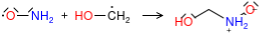

H2NO(88) + CH2OH(45) <=> S(1693)
Arrhenius(A=(6.89518e+79,'cm^3/(mol*s)'), n=-21.017, Ea=(0,'kcal/mol'), T0=(1,'K'))
BM rule fitted to 2 training reactions at node Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C Total Standard Deviation in ln(k): 11.5401827615
Exact match found for rate rule [Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C]
Euclidian distance = 0
family: R_Recombination
Direction: forward
Violation factor: 2e+10
Violation condition: 423 K, 1.0 bar




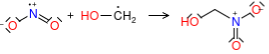

NO2(9) + CH2OH(45) <=> S(1677)
Arrhenius(A=(6.89518e+79,'cm^3/(mol*s)'), n=-21.017, Ea=(0,'kcal/mol'), T0=(1,'K'))
BM rule fitted to 2 training reactions at node Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C Total Standard Deviation in ln(k): 11.5401827615
Exact match found for rate rule [Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C]
Euclidian distance = 0
family: R_Recombination
Direction: forward
Violation factor: 1.9e+10
Violation condition: 423 K, 1.0 bar




CH3(18) <=> H2(13) + CH(44)
ThirdBody(arrheniusLow=Arrhenius(A=(3.1e+15,'cm^3/(mol*s)'), n=0, Ea=(80.871,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 6.4e+09
Violation condition: 423 K, 30.0 bar




CH3NO(142) <=> H(20) + H2NCO(146)
ThirdBody(arrheniusLow=Arrhenius(A=(4.6e+15,'cm^3/(mol*s)'), n=0, Ea=(64.2,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 3.5e+09
Violation condition: 423 K, 1.0 bar




CH3(18) <=> H(20) + CH2(42)
ThirdBody(arrheniusLow=Arrhenius(A=(2.2e+15,'cm^3/(mol*s)'), n=0, Ea=(82.659,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 8.6e+08
Violation condition: 423 K, 1.0 bar




OH(24) + H2N2(97) => NO(10) + H(20) + NH2(85)
Arrhenius(A=(2e+12,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Kinetic library: NOx2018
Direction: reverse
Violation factor: 7.3e+08
Violation condition: 423 K, 1.0 bar




CH3NO(142) <=> NH2(85) + HCO(22)
ThirdBody(arrheniusLow=Arrhenius(A=(1.4e+16,'cm^3/(mol*s)'), n=0, Ea=(72.9,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 3.3e+08
Violation condition: 423 K, 30.0 bar




CH3(18) <=> H2(13) + CH(44)
ThirdBody(arrheniusLow=Arrhenius(A=(3.1e+15,'cm^3/(mol*s)'), n=0, Ea=(80.871,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 2.1e+08
Violation condition: 423 K, 1.0 bar




NH3(2) + CH(44) <=> H(20) + H(20) + H2CN(114)
Arrhenius(A=(4.4e+13,'cm^3/(mol*s)'), n=0, Ea=(-0.63,'kcal/mol'), T0=(1,'K'))
Kinetic library: NOx2018
Direction: reverse
Violation factor: 6.8e+07
Violation condition: 423 K, 1.0 bar




CH3NO(142) <=> NH2(85) + HCO(22)
ThirdBody(arrheniusLow=Arrhenius(A=(1.4e+16,'cm^3/(mol*s)'), n=0, Ea=(72.9,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 1.1e+07
Violation condition: 423 K, 1.0 bar




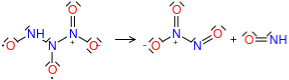

S(1436) <=> NO2NO(328) + HNO(87)
Arrhenius(A=(5e+12,'s^-1'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Exact match found for rate rule [RJJ]
Euclidian distance = 0
family: 1,4_Linear_birad_scission
Direction: reverse
Violation factor: 1.1e+06
Violation condition: 1000 K, 1.0 bar




C2H2(52) <=> H(20) + C2H(53)
ThirdBody(arrheniusLow=Arrhenius(A=(9.1e+30,'cm^3/(mol*s)'), n=-3.7, Ea=(127.138,'kcal/mol'), T0=(1,'K')), efficiencies={Molecule(smiles="[C-]#[O+]"): 2.0, Molecule(smiles="[H][H]"): 2.0, Molecule(smiles="O=C=O"): 3.0, Molecule(smiles="O"): 5.0})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 1.6e+04
Violation condition: 423 K, 30.0 bar




O(36) + HNCNH(109) <=> OH(24) + HNCN(107)
Arrhenius(A=(3.4e+08,'cm^3/(mol*s)'), n=1.5, Ea=(4.63,'kcal/mol'), T0=(1,'K'))
Kinetic library: NOx2018
Direction: reverse
Violation factor: 5e+03
Violation condition: 423 K, 1.0 bar




H2(13) + NCN(108) <=> H(20) + HNCN(107)
Arrhenius(A=(4.1e+13,'cm^3/(mol*s)'), n=0, Ea=(24.1,'kcal/mol'), T0=(1,'K'))
Kinetic library: NOx2018
Direction: reverse
Violation factor: 4.8e+03
Violation condition: 1000 K, 1.0 bar




CH2(42) <=> H(20) + CH(44)
ThirdBody(arrheniusLow=Arrhenius(A=(5.6e+15,'cm^3/(mol*s)'), n=0, Ea=(89,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 2.8e+03
Violation condition: 423 K, 30.0 bar




O(36) + C2H7N(157) <=> OH(24) + C2H6N(158)
Arrhenius(A=(3e+12,'cm^3/(mol*s)'), n=0, Ea=(0.556,'kcal/mol'), T0=(1,'K'))
Kinetic library: NOx2018
Direction: reverse
Violation factor: 2e+03
Violation condition: 423 K, 1.0 bar




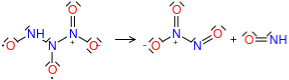

S(1436) <=> NO2NO(328) + HNO(87)
Arrhenius(A=(5e+12,'s^-1'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Exact match found for rate rule [RJJ]
Euclidian distance = 0
family: 1,4_Linear_birad_scission
Direction: reverse
Violation factor: 1e+03
Violation condition: 423 K, 1.0 bar




C2H2(52) <=> H(20) + C2H(53)
ThirdBody(arrheniusLow=Arrhenius(A=(9.1e+30,'cm^3/(mol*s)'), n=-3.7, Ea=(127.138,'kcal/mol'), T0=(1,'K')), efficiencies={Molecule(smiles="[C-]#[O+]"): 2.0, Molecule(smiles="[H][H]"): 2.0, Molecule(smiles="O=C=O"): 3.0, Molecule(smiles="O"): 5.0})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 5.3e+02
Violation condition: 423 K, 1.0 bar




CH2O(17) + C2H5O3(77) => HCO(22) + CH2OH(45) + CH2OOH(55)
Arrhenius(A=(41000,'cm^3/(mol*s)'), n=2.5, Ea=(10.206,'kcal/mol'), T0=(1,'K'))
Kinetic library: NOx2018
Direction: reverse
Violation factor: 2.6e+02
Violation condition: 1000 K, 1.0 bar




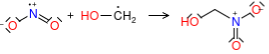

NO2(9) + CH2OH(45) <=> S(1677)
Arrhenius(A=(6.89518e+79,'cm^3/(mol*s)'), n=-21.017, Ea=(0,'kcal/mol'), T0=(1,'K'))
BM rule fitted to 2 training reactions at node Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C Total Standard Deviation in ln(k): 11.5401827615
Exact match found for rate rule [Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C]
Euclidian distance = 0
family: R_Recombination
Direction: forward
Violation factor: 2.3e+02
Violation condition: 1000 K, 1.0 bar




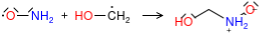

H2NO(88) + CH2OH(45) <=> S(1693)
Arrhenius(A=(6.89518e+79,'cm^3/(mol*s)'), n=-21.017, Ea=(0,'kcal/mol'), T0=(1,'K'))
BM rule fitted to 2 training reactions at node Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C Total Standard Deviation in ln(k): 11.5401827615
Exact match found for rate rule [Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C]
Euclidian distance = 0
family: R_Recombination
Direction: forward
Violation factor: 2.3e+02
Violation condition: 1000 K, 1.0 bar




NO(10) + NO(10) <=> N2O2(378)
Arrhenius(A=(5.1562e+36,'cm^3/(mol*s)'), n=-7.489, Ea=(1.348,'kcal/mol'), T0=(1,'K'))
BM rule fitted to 2 training reactions at node Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0 Total Standard Deviation in ln(k): 12.7194203157
Exact match found for rate rule [Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0]
Euclidian distance = 0
family: R_Recombination
Direction: forward
Violation factor: 1.2e+02
Violation condition: 423 K, 1.0 bar




CH2(42) <=> H(20) + CH(44)
ThirdBody(arrheniusLow=Arrhenius(A=(5.6e+15,'cm^3/(mol*s)'), n=0, Ea=(89,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 94
Violation condition: 423 K, 1.0 bar




CH3(18) <=> H(20) + CH2(42)
ThirdBody(arrheniusLow=Arrhenius(A=(2.2e+15,'cm^3/(mol*s)'), n=0, Ea=(82.659,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 52
Violation condition: 1000 K, 30.0 bar




H(20) + HNCNH(109) <=> H2(13) + HNCN(107)
Arrhenius(A=(4.8e+08,'cm^3/(mol*s)'), n=1.5, Ea=(7.322,'kcal/mol'), T0=(1,'K'))
Kinetic library: NOx2018
Direction: reverse
Violation factor: 51
Violation condition: 423 K, 1.0 bar




C2O(74) <=> C(51) + CO(14)
ThirdBody(arrheniusLow=Arrhenius(A=(2e+15,'cm^3/(mol*s)'), n=0, Ea=(44.2,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 42
Violation condition: 423 K, 30.0 bar




CH3NO(142) <=> H(20) + H2NCO(146)
ThirdBody(arrheniusLow=Arrhenius(A=(4.6e+15,'cm^3/(mol*s)'), n=0, Ea=(64.2,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 40
Violation condition: 1000 K, 30.0 bar




CH3(18) <=> H2(13) + CH(44)
ThirdBody(arrheniusLow=Arrhenius(A=(3.1e+15,'cm^3/(mol*s)'), n=0, Ea=(80.871,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 36
Violation condition: 1000 K, 30.0 bar




CH2(42) <=> H2(13) + C(51)
ThirdBody(arrheniusLow=Arrhenius(A=(5.8e+12,'cm^3/(mol*s)'), n=0.5, Ea=(68.5,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: NOx2018
Direction: reverse
Violation factor: 22
Violation condition: 423 K, 30.0 bar




OH(24) + C2H4N(145) <=> HCNH(135) + CH2OH(45)
Arrhenius(A=(1e+13,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Kinetic library: NOx2018
Direction: reverse
Violation factor: 17
Violation condition: 423 K, 1.0 bar




H(20) + S(122) <=> H2(13) + S(123)
Arrhenius(A=(4.4e+08,'cm^3/(mol*s)'), n=1.5, Ea=(0.378,'kcal/mol'), T0=(1,'K'))
Kinetic library: NOx2018
Direction: reverse
Violation factor: 7.6
Violation condition: 423 K, 1.0 bar




In [15]:
families = Counter()
templates = Counter()
rate_rules = Counter()
problem_species = Counter()
for violator in violators:
    rxn_string = str(violator[0])
    kinetics = violator[0].kinetics
    comment = ''
    if isinstance(violator[0], TemplateReaction):
        comment = violator[0].kinetics.comment
        violator[0].kinetics.comment = ''  # the comment is printed better when outside of the object
    if isinstance(violator[0], LibraryReaction):
        comment = 'Kinetic library: {0}'.format(violator[0].library)
    if isinstance(violator[0], PDepReaction):
        comment = 'Network #{0}'.format(violator[0].network)
    direction = violator[1]
    ratio = violator[2]
    condition = violator[3]
    
    problem_species.update(violator[0].reactants)
    problem_species.update(violator[0].products)
    
    m = re.search('family: (.*)', comment)
    if m:
        families[m.group(1)] += 1
    n = re.search('rate rule (.*)', comment)
    if n:
        rate_rules[m.group(1) + n.group(1)] += 1
    n = re.search('using template (\S+)', comment)
    if n:
        templates[m.group(1) + n.group(1)] += 1
    
    if ratio < 5:
        continue # only print the big ones!
    
    display(violator[0])
    print('{0}\n{1}\n{2}\nDirection: {3}\nViolation factor: {4:.2g}\n'
                      'Violation condition: {5}\n\n'.format(rxn_string, kinetics, comment, direction,
                                                            ratio, condition))
    if isinstance(violator[0], TemplateReaction):
        # although this is the end of the run, restore the original comment
        violator[0].kinetics.comment = comment

In [16]:
families.most_common(10)

[('R_Recombination', 5), ('1,4_Linear_birad_scission', 2)]

In [17]:
# This is what was used
templates.most_common(10)

[]

In [18]:
# This is what it was trying to use
rate_rules.most_common(10)

[('R_Recombination[Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C]', 4),
 ('1,4_Linear_birad_scission[RJJ]', 2),
 ('R_Recombination[Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0]', 1)]

In [19]:
# Most common species
for s,n in problem_species.most_common(20):
    print(f"{str(s):10s}  {n:3d}  {s.thermo.comment[:40]}")

H(20)        23  Thermo library: primaryThermoLibrary
H2(13)        9  Thermo library: primaryThermoLibrary
CH3(18)       9  Thermo library: thermo_DFT_CCSDTF12_BAC
CH2OH(45)     8  Thermo library: thermo_DFT_CCSDTF12_BAC
CH3NO(142)    7  Thermo library: NOx2018
CH2(42)       7  Thermo library: primaryThermoLibrary
CH(44)        7  Thermo library: DFT_QCI_thermo
HCO(22)       5  Thermo library: thermo_DFT_CCSDTF12_BAC
HNCN(107)     5  Thermo library: thermo_DFT_CCSDTF12_BAC
OH(24)        5  Thermo library: primaryThermoLibrary
NH2(85)       5  Thermo library: primaryThermoLibrary
H2NCO(146)    4  Thermo library: NOx2018
NO2(9)        4  Thermo library: thermo_DFT_CCSDTF12_BAC
NO(10)        4  Thermo library: thermo_DFT_CCSDTF12_BAC
C2H5O3(77)    3  Thermo library: NOx2018
CH2OOH(55)    3  Thermo library: NOx2018
H2NO(88)      3  Thermo library: thermo_DFT_CCSDTF12_BAC
C2H2(52)      3  Thermo library: thermo_DFT_CCSDTF12_BAC
C2H(53)       3  Thermo library: thermo_DFT_CCSDTF12_BAC
O(36)

In [20]:
for s,n in problem_species.most_common(10):
    display(s)
    print(s)
    print(s.molecule[0].to_adjacency_list())
    print(s.thermo.comment)
    print('-'*80)

H(20)
multiplicity 2
1 H u1 p0 c0

Thermo library: primaryThermoLibrary
--------------------------------------------------------------------------------


H2(13)
1 H u0 p0 c0 {2,S}
2 H u0 p0 c0 {1,S}

Thermo library: primaryThermoLibrary
--------------------------------------------------------------------------------


CH3(18)
multiplicity 2
1 C u1 p0 c0 {2,S} {3,S} {4,S}
2 H u0 p0 c0 {1,S}
3 H u0 p0 c0 {1,S}
4 H u0 p0 c0 {1,S}

Thermo library: thermo_DFT_CCSDTF12_BAC
--------------------------------------------------------------------------------


CH2OH(45)
multiplicity 2
1 O u0 p2 c0 {2,S} {5,S}
2 C u1 p0 c0 {1,S} {3,S} {4,S}
3 H u0 p0 c0 {2,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {1,S}

Thermo library: thermo_DFT_CCSDTF12_BAC
--------------------------------------------------------------------------------


CH3NO(142)
1 O u0 p2 c0 {3,D}
2 N u0 p1 c0 {3,S} {4,S} {5,S}
3 C u0 p0 c0 {1,D} {2,S} {6,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {2,S}
6 H u0 p0 c0 {3,S}

Thermo library: NOx2018
--------------------------------------------------------------------------------


CH2(42)
multiplicity 3
1 C u2 p0 c0 {2,S} {3,S}
2 H u0 p0 c0 {1,S}
3 H u0 p0 c0 {1,S}

Thermo library: primaryThermoLibrary
--------------------------------------------------------------------------------


CH(44)
multiplicity 2
1 C u1 p1 c0 {2,S}
2 H u0 p0 c0 {1,S}

Thermo library: DFT_QCI_thermo
--------------------------------------------------------------------------------


HCO(22)
multiplicity 2
1 O u0 p2 c0 {2,D}
2 C u1 p0 c0 {1,D} {3,S}
3 H u0 p0 c0 {2,S}

Thermo library: thermo_DFT_CCSDTF12_BAC
--------------------------------------------------------------------------------


HNCN(107)
multiplicity 2
1 N u0 p1 c0 {3,D} {4,S}
2 N u1 p1 c0 {3,D}
3 C u0 p0 c0 {1,D} {2,D}
4 H u0 p0 c0 {1,S}

Thermo library: thermo_DFT_CCSDTF12_BAC
--------------------------------------------------------------------------------


OH(24)
multiplicity 2
1 O u1 p2 c0 {2,S}
2 H u0 p0 c0 {1,S}

Thermo library: primaryThermoLibrary
--------------------------------------------------------------------------------
